# Game Version Analysis

## Import Library

In [50]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

# A/b Testing 
from scipy.stats import shapiro, bartlett, ttest_ind, mannwhitneyu, norm
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
from math import sqrt

# Table of Content

1. [Business Understanding](#1)
2. [Data Understanding](#2)
4. [Data  Preparation](#3)
5. [EDA](#4)
6. [A/B Testing](#5)

# 1. Business Understanding <a name="1"></a>

`Cookie Cats` is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game, where the player must connect tiles of the same colour in order to clear the board and win the level. It also features singing cats. We're not kidding!

As players progress through the game, they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyse the result of an `A/B test` _**where the first gate in Cookie Cats was moved from level 30 to level 40**_. In particular, we will analyse the impact on `player retention` and `game rounds`.

To complete this project, you should be comfortable working with pandas Data Frames and with using the pandas plot method. You should also have some understanding of `hypothesis testing` and `bootstrap analysis`.

# 2. Data Understanding <a name="2"></a>

1. `user id` : a unique number that identifies each player
2. `version` : whether the player was put in the control group (**gate_30** - a gate at level 30) or test group (**gate_40** - a gate at level 40)
3. `sum_gamerounds` : the number of game rounds played by the player during the first week after installation
4. `retention_1` : did the player come back and play 1 day after installing? (either TRUE or False)
5. `retention_7` :  did the player come back and play 7 day after installing? (either TRUE or False)

In [61]:
# Load csv 
data = pd.read_csv("cookie_cats.csv")

In [65]:
# Display First N Row 
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [67]:
# Dimension of the dataframe 
print(f'Number of rows: {data.shape[0]}')
print(f'Number of columns: {data.shape[1]}')

Number of rows: 90189
Number of columns: 5


# 3. Data Preparation <a name="3"></a>

In [69]:
# Check Null Value 
data.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [75]:
# Check Duplicate Value
data.duplicated().sum()

0

In [77]:
# Summary Statistic 
data.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [81]:
# Check dtypes of each column 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [92]:
# Check unique value and freqeuncy of categorical columns 
# Select categorical and boolean columns
category_col = data.select_dtypes(["object", "bool"])

# Iterate over each column to calculate unique values and their frequencies
for col in category_col.columns:
    print(f'Column: {col} | Unique Values: {category_col[col].nunique()}')
    print(category_col[col].value_counts())
    print("-" * 50)

Column: version | Unique Values: 2
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64
--------------------------------------------------
Column: retention_1 | Unique Values: 2
retention_1
False    50036
True     40153
Name: count, dtype: int64
--------------------------------------------------
Column: retention_7 | Unique Values: 2
retention_7
False    73408
True     16781
Name: count, dtype: int64
--------------------------------------------------


# 4. EDA <a name="4"></a>

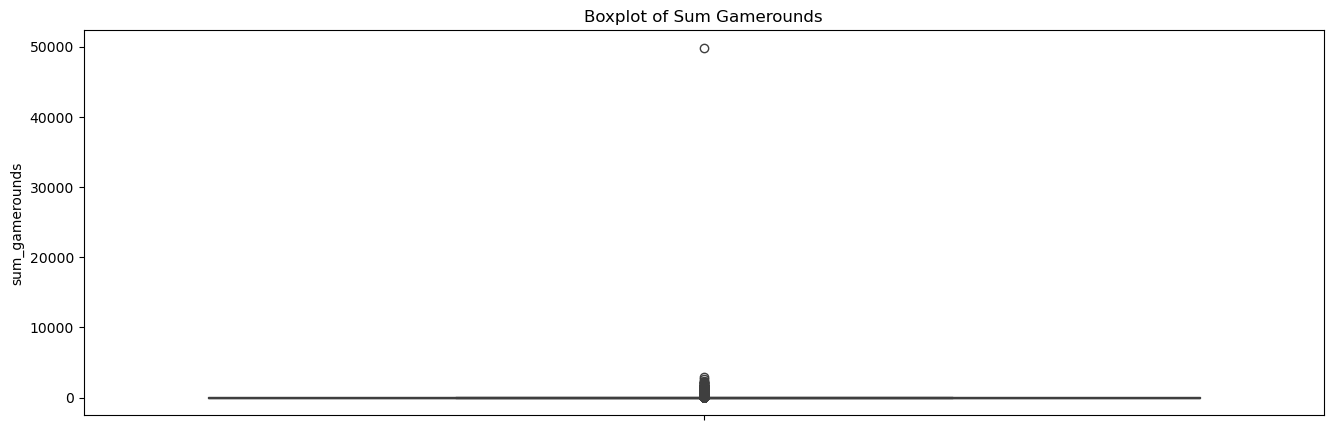

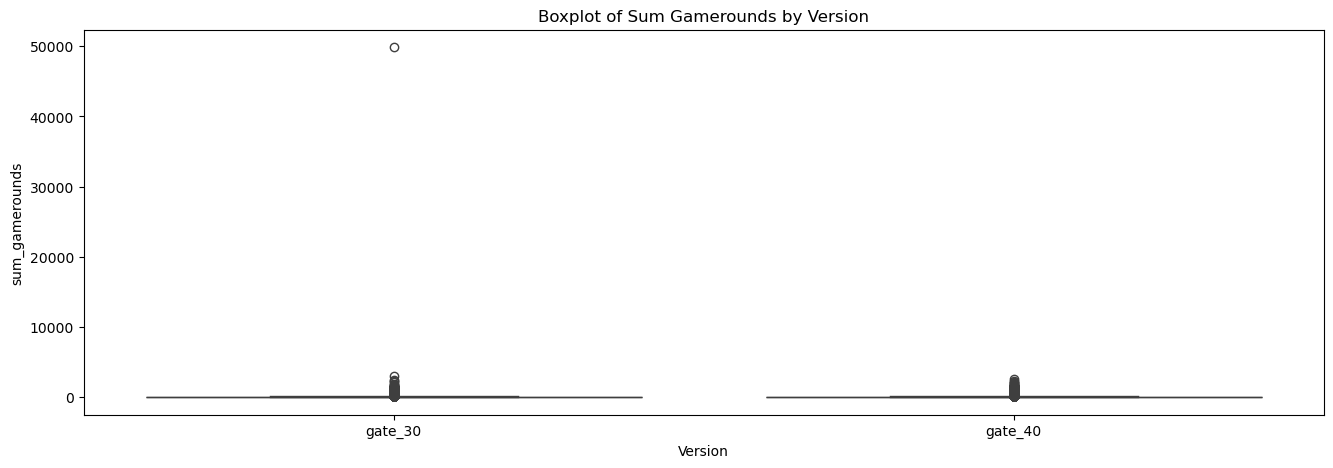

In [102]:
# Check for outliers using a boxplot
plt.figure(figsize=(16, 5))  
sns.boxplot(y=data['sum_gamerounds'])
plt.title('Boxplot of Sum Gamerounds')
plt.show()

# Check for outliers using a boxplot by version
plt.figure(figsize=(16, 5)) 
sns.boxplot(x=data['version'], y=data['sum_gamerounds'], data=data)
plt.title('Boxplot of Sum Gamerounds by Version')
plt.xlabel('Version')
plt.show()

In [112]:
col = 'sum_gamerounds'

# Calculate Q1, Q3, and IQR for 'total_price'
Q1 = data[col].quantile(0.25)
Q3 = data[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the rows that are within the bounds (no outliers)
data_filtered = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

In [120]:
# Dimension of data_filtered dataframe 
print(f'Number of rows: {data_filtered.shape[0]}')
print(f'Number of columns: {data_filtered.shape[1]}')

Number of rows: 80012
Number of columns: 5


In [118]:
# Dimension of data dataframe 
print(f'Number of rows: {data.shape[0]}')
print(f'Number of columns: {data.shape[1]}')

Number of rows: 90189
Number of columns: 5


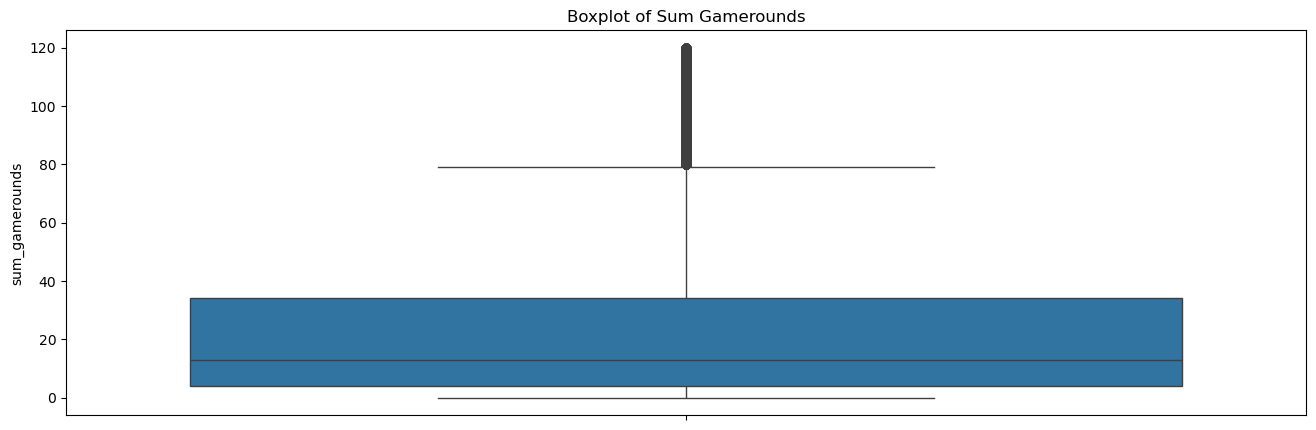

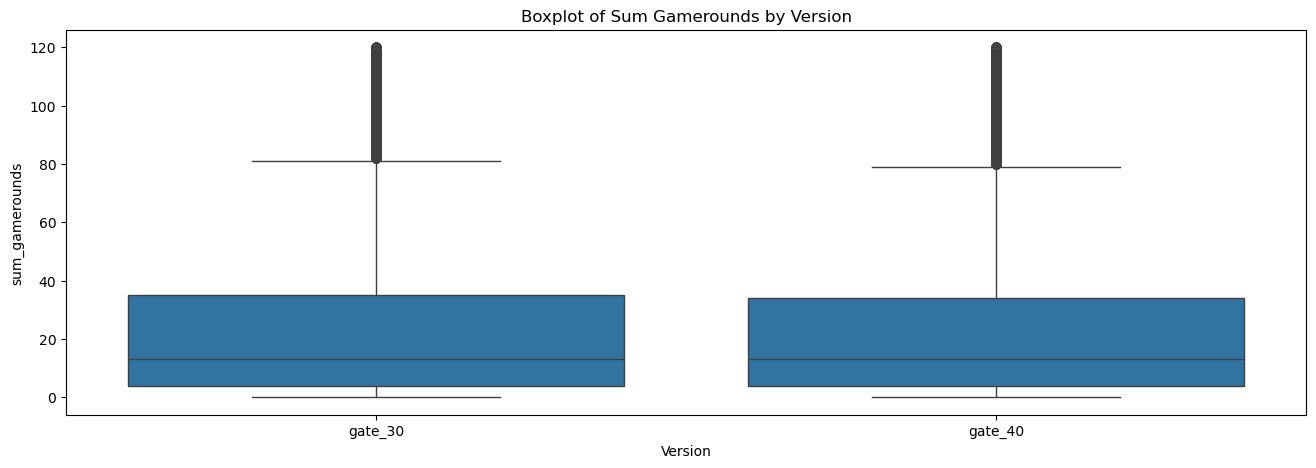

In [124]:
# Boxplot 
plt.figure(figsize=(16, 5))  
sns.boxplot(y=data_filtered['sum_gamerounds'])
plt.title('Boxplot of Sum Gamerounds')
plt.show()

# Boxplot by version
plt.figure(figsize=(16, 5)) 
sns.boxplot(x=data_filtered['version'], y=data_filtered['sum_gamerounds'], data=data_filtered)
plt.title('Boxplot of Sum Gamerounds by Version')
plt.xlabel('Version')
plt.show()

In [138]:
# Total gamerounds by version
print(data_filtered.groupby('version').agg({'sum_gamerounds':'sum', 'version':'count'}))
print('-' *50)

# Total retention_1 by version, rentention_1
print(data_filtered.groupby(['version', 'retention_1']).agg({'sum_gamerounds':'sum', 'retention_1':'count'}))
print('-' *50)

# Total retention_7 by version, retention_7
print(data_filtered.groupby(['version', 'retention_7']).agg({'sum_gamerounds':'sum', 'retention_7':'count'}))

         sum_gamerounds  version
version                         
gate_30          949139    39638
gate_40          969483    40374
--------------------------------------------------
                     sum_gamerounds  retention_1
version retention_1                             
gate_30 False                306142        24215
        True                 642997        15423
gate_40 False                315063        24896
        True                 654420        15478
--------------------------------------------------
                     sum_gamerounds  retention_7
version retention_7                             
gate_30 False                687973        34956
        True                 261166         4682
gate_40 False                714850        35941
        True                 254633         4433


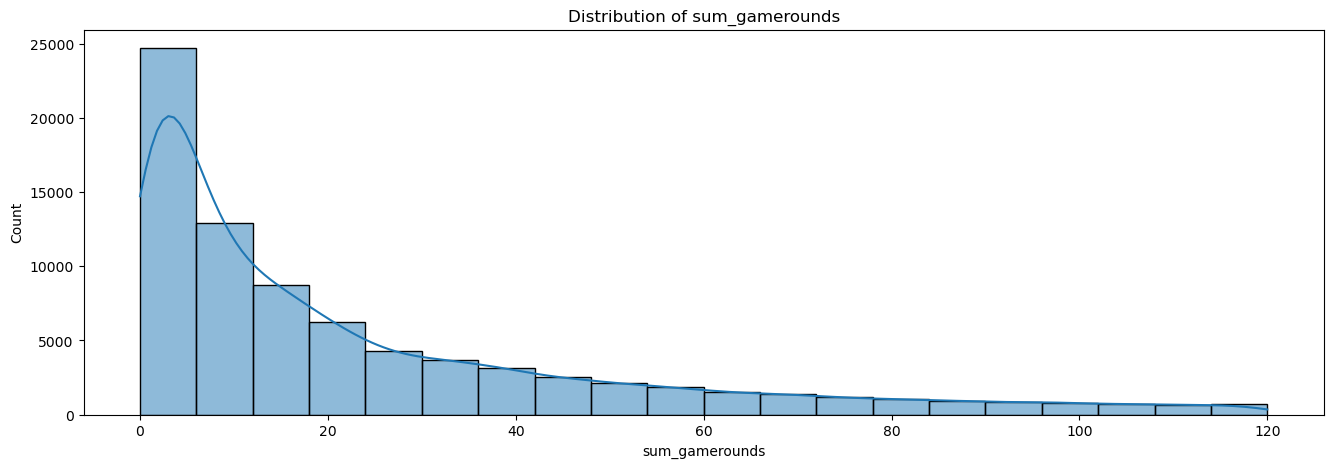

In [142]:
# Histogram for sum_gamerounds
plt.figure(figsize=(16, 5))
sns.histplot(data_filtered[col], kde=True, bins=20)
plt.title(f'Distribution of {col}')
plt.show()

# 5. A/B Testing <a name="5"></a>

### a. Sum_Gamerounds by Version - Numeric

In [155]:
# Assign Control group & Test group 
control = data_filtered[data_filtered['version']=='gate_30']['sum_gamerounds']
test = data_filtered[data_filtered['version']=='gate_40']['sum_gamerounds']

In [161]:
print(control.shape)
print(test.shape)

(39638,)
(40374,)


Control Group - Mean: 23.945178868762298, Std: 27.152546630062, Sample Size: 39638
Test Group - Mean: 24.012557586565613, Std: 27.800704444216763, Sample Size: 40374


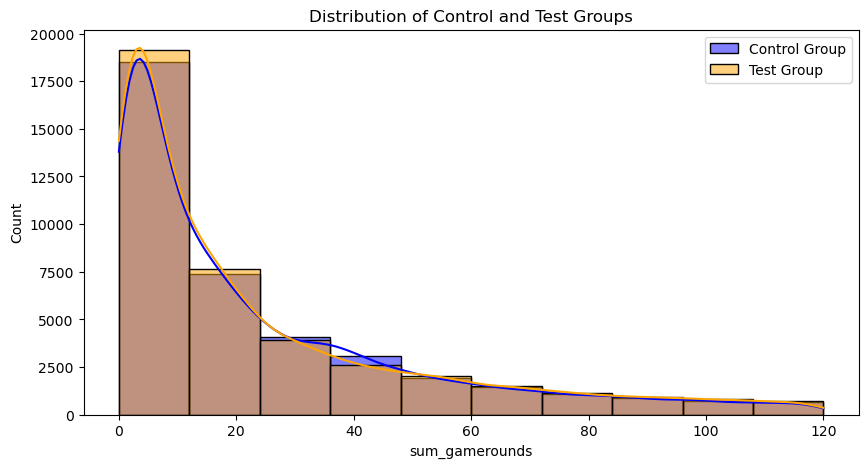

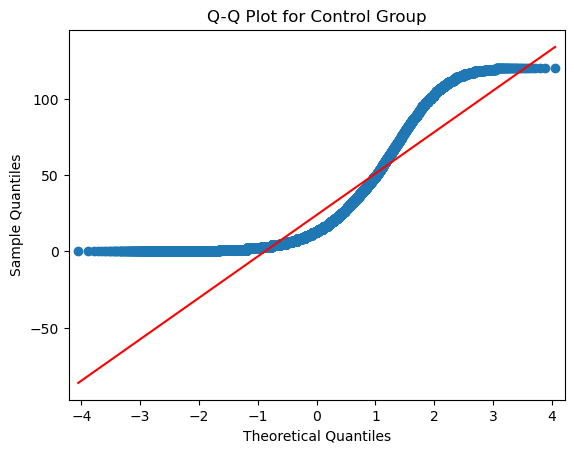

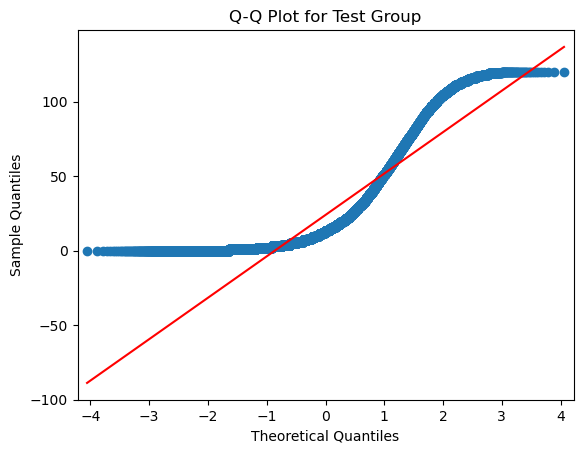

Control Group Normal: False, Test Group Normal: False

Test Type: Mann-Whitney U Test (non-parametric)
Statistic: 806916458.0
P-value: 0.03885510150342266
Effect Size (Cohen's d): 0.347 (Moderate)
Confidence Interval: (-0.3134006097170453, 0.44815804532367565)
Interpretation: Reject Null Hypothesis



C:\Users\lic02\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 39638.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\lic02\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 40374.
  res = hypotest_fun_out(*samples, **kwds)


In [163]:
# Step 1: Calculate mean, standard deviation, and sample size
control_mean = control.mean()
control_std = control.std(ddof=1)
control_n = len(control)

test_mean = test.mean()
test_std = test.std(ddof=1)
test_n = len(test)

print(f"Control Group - Mean: {control_mean}, Std: {control_std}, Sample Size: {control_n}")
print(f"Test Group - Mean: {test_mean}, Std: {test_std}, Sample Size: {test_n}")

# Step 2: Visualize distributions
plt.figure(figsize=(10, 5))
sns.histplot(control, kde=True, label='Control Group', color='blue', alpha=0.5, bins=10)
sns.histplot(test, kde=True, label='Test Group', color='orange', alpha=0.5, bins=10)
plt.legend()
plt.title("Distribution of Control and Test Groups")
plt.show()

# Step 3: Generate Q-Q plots
qqplot(control, line='s')
plt.title("Q-Q Plot for Control Group")
plt.show()

qqplot(test, line='s')
plt.title("Q-Q Plot for Test Group")
plt.show()

# Step 4: Apply Shapiro-Wilk test for normality
control_normal = shapiro(control).pvalue > 0.05
test_normal = shapiro(test).pvalue > 0.05

print(f"Control Group Normal: {control_normal}, Test Group Normal: {test_normal}")

if control_normal and test_normal:
    # Step 5: Check for homogeneity of variances
    equal_var = bartlett(control, test).pvalue > 0.05
    print(f"Equal Variances (Bartlett Test): {equal_var}")

    # Step 6: Perform parametric tests
    if equal_var:
        stat, pvalue = ttest_ind(control, test, equal_var=True)
        test_type = "T-Test (equal variances)"
    else:
        stat, pvalue = ttest_ind(control, test, equal_var=False)
        test_type = "Welch Test (unequal variances)"
else:
    # Step 7: Perform non-parametric test
    stat, pvalue = mannwhitneyu(control, test)
    test_type = "Mann-Whitney U Test (non-parametric)"

# Step 8: Calculate effect size (Cohen's d)
pooled_std = sqrt(((control_std**2) / control_n) + ((test_std**2) / test_n))
effect_size = (test_mean - control_mean) / pooled_std

# Step 9: Calculate confidence interval
z_critical = 1.96  # For 95% confidence
margin_of_error = z_critical * pooled_std
conf_interval = (test_mean - control_mean - margin_of_error, test_mean - control_mean + margin_of_error)

# Step 10: Output results
interpretation = "Reject Null Hypothesis" if pvalue < 0.05 else "Fail to Reject Null Hypothesis"
print(f"""
Test Type: {test_type}
Statistic: {stat}
P-value: {pvalue}
Effect Size (Cohen's d): {effect_size:.3f} ({'Small' if effect_size < 0.2 else 'Moderate' if effect_size < 0.5 else 'Large'})
Confidence Interval: {conf_interval}
Interpretation: {interpretation}
""")

### b. Retention_1 by Version - Boolean

#### Hypothesis Testing:
- Null Hypothesis (H₀): The proportion of the player coming back and playing 1 day after installing (Retention_1 = True) is the same in both groups.

- Alternative Hypothesis (H₁): The proportion of the player coming back and playing 1 day after installing (Retention_1 = True) differs between groups.

In [169]:
# Count of True values using value_counts()
control_1 = data_filtered[data_filtered['version']=='gate_30']
test_1 = data_filtered[data_filtered['version']=='gate_40']

In [171]:
print(control_1.shape)
print(test_1.shape) 

(39638, 5)
(40374, 5)


In [181]:
# Count of True and False values using value_counts()
control_true = control_1['retention_1'].value_counts().get(True, 0)
control_false = control_1['retention_1'].value_counts().get(False, 0)
test_true = test_1['retention_1'].value_counts().get(True, 0)
test_false = test_1['retention_1'].value_counts().get(False, 0)

In [187]:
# Chi-square test
from scipy.stats import chi2_contingency

data_test = [[control_true, control_false], [test_true, test_false]]

chi2, p, dof, expected = chi2_contingency(data_test)

print(f"Chi-Square Statistic: {chi2}, p-value: {p}")
if p < 0.05:
    print("Reject the null hypothesis (significant difference).")
else:
    print("Fail to reject the null hypothesis (no significant difference).")

Chi-Square Statistic: 2.7469392649060054, p-value: 0.09744079493080224
Fail to reject the null hypothesis (no significant difference).


In [185]:
# Z-Test for Proportions
from statsmodels.stats.proportion import proportions_ztest

# True counts and total counts for each group
true_counts = [control_true, test_true]
n_obs = [control_1.shape[0], test_1.shape[0]]

z_stat, p = proportions_ztest(true_counts, n_obs)

print(f"Z-Statistic: {z_stat}, p-value: {p}")
if p < 0.05:
    print("Reject the null hypothesis (significant difference).")
else:
    print("Fail to reject the null hypothesis (no significant difference).")

Z-Statistic: 1.6646506905825758, p-value: 0.09598246591228181
Fail to reject the null hypothesis (no significant difference).


### c. Retention_7 by Version - Boolean

#### Hypothesis Testing:
- Null Hypothesis (H₀): The proportion of the player coming back and playing 7 day after installing (Retention_7 = True) is the same in both groups.

- Alternative Hypothesis (H₁): The proportion of the player coming back and playing 7 day after installing (Retention_7 = True) differs between groups.

In [190]:
# Count of True and False values using value_counts()
control_true1 = control_1['retention_7'].value_counts().get(True, 0)
control_false1 = control_1['retention_7'].value_counts().get(False, 0)
test_true1 = test_1['retention_7'].value_counts().get(True, 0)
test_false1 = test_1['retention_7'].value_counts().get(False, 0)

In [192]:
# Chi-square test
from scipy.stats import chi2_contingency

data_test1 = [[control_true1, control_false1], [test_true1, test_false1]]

chi2, p, dof, expected = chi2_contingency(data_test1)

print(f"Chi-Square Statistic: {chi2}, p-value: {p}")
if p < 0.05:
    print("Reject the null hypothesis (significant difference).")
else:
    print("Fail to reject the null hypothesis (no significant difference).")

Chi-Square Statistic: 13.635749319036979, p-value: 0.0002219192789538602
Reject the null hypothesis (significant difference).


In [194]:
# Z-Test for Proportions
from statsmodels.stats.proportion import proportions_ztest

# True counts and total counts for each group
true_counts1 = [control_true1, test_true1]
n_obs1 = [control_1.shape[0], test_1.shape[0]]

z_stat, p = proportions_ztest(true_counts1, n_obs1)

print(f"Z-Statistic: {z_stat}, p-value: {p}")
if p < 0.05:
    print("Reject the null hypothesis (significant difference).")
else:
    print("Fail to reject the null hypothesis (no significant difference).")

Z-Statistic: 3.7037892049869834, p-value: 0.00021240277684542175
Reject the null hypothesis (significant difference).


In [196]:
# Proportions
p_A = control_true1 / control_1.shape[0]
p_B = test_true1 / test_1.shape[0]

# Effect Sizes
risk_difference = p_B - p_A
relative_risk = p_B / p_A
odds_A = p_A / (1 - p_A)
odds_B = p_B / (1 - p_B)
odds_ratio = odds_B / odds_A

print(f"Risk Difference: {risk_difference}")
print(f"Relative Risk: {relative_risk}")
print(f"Odds Ratio: {odds_ratio}")

Risk Difference: -0.008320591640171071
Relative Risk: 0.9295575370711019
Odds Ratio: 0.9208690910578078


1. **Risk Difference**: The changes implemented for the group `gate_40` (e.g., a different game onboarding process or ad targeting strategy) resulted in a slightly lower retention rate than the group `gate_30`.
2. **Relative Risk**: Players in Group `gate_40` were less likely to return within 7 days, possibly due to differences in onboarding, game features, or other factors tested in this group.
3. **Odds Ratio** : If the odds of a player returning in Group `gate_30` are x:1, then the odds in Group `gate_40` are 0.92x:1.
4. **Conclusion** : Group `gate_40`'s retention rate (players returning within 7 days) is slightly lower than Group `gate_30`.

In [212]:
# Effect size: Risk Difference CI
from statsmodels.stats.proportion import proportion_confint

# Confidence Intervals for success proportions
ci_A = proportion_confint(control_true1, control_1.shape[0], alpha=0.05, method='normal')
ci_B = proportion_confint(test_true1, test_1.shape[0], alpha=0.05, method='normal')

print(f"Confidence Interval for Group A Proportion: {ci_A}")
print(f"Confidence Interval for Group B Proportion: {ci_B}")

Confidence Interval for Group A Proportion: (0.11494168523857369, 0.12129626824041113)
Confidence Interval for Group B Proportion: (0.10674880976090315, 0.11284796043773954)


In [214]:
# Effect size: Odds Ratio CI:
import numpy as np
from scipy.stats import norm

# Log Odds Ratio
log_or = np.log(odds_ratio)

# Standard Error of Log Odds Ratio
se_log_or = np.sqrt(
    1 / control_true1 + 
    1 / (control_1.shape[0] - control_true1) + 
    1 / test_true1 + 
    1 / (test_1.shape[0] - test_true1)
)

# Confidence Interval
z = norm.ppf(0.975)  # 95% confidence level
ci_lower = np.exp(log_or - z * se_log_or)
ci_upper = np.exp(log_or + z * se_log_or)

print(f"Odds Ratio: {odds_ratio}")
print(f"Confidence Interval: ({ci_lower}, {ci_upper})")

Odds Ratio: 0.9208690910578078
Confidence Interval: (0.8815530812619764, 0.9619385388020983)
